# Ridge Regression

#### Author: Yiran Jing

#### Date: Feb 2020


## Contents:
1. Model selection
   - Linear regression
   - Ridge regression
   - Lasso regression
   
Lasso performs best using `Days`, `suspected`, `confirmed_lag1` as regressors

2. Ridge Residual Dignostic

3. Model prediction

## Summary

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
import datetime
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
# Import models from scikit learn module
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, ElasticNetCV
from helper_fun_model import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
## Update data from DXY
! cd ../data_processing && python DXY_AreaData_query.py

2020-02-12 21:42:12Update records successfully to ../data/DXY_Chinese.csv
Save area daily dataset (English) into ../data/DXYArea.csv
CPU times: user 157 ms, sys: 49.9 ms, total: 207 ms
Wall time: 11.5 s


In [3]:
## Load data 
df = pd.read_csv("../data/DXYArea.csv")
"""
Data Cleaning 
"""
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] != df['date'].max()] # remove todays' records (since it can be incompleted)

In [4]:
df = df[df['date']>'2020-01-14']

### Case 1: Overall China

In [5]:
china_df = get_China_total(df)

In [6]:
#features_to_engineer = ['confirmed', 'suspected']
features_to_engineer = ['confirmed'] # only calculate lag 1 for predictor, not regressor.

In [7]:
china_df = feature_engineering(china_df, features_to_engineer)

In [8]:
china_df.tail(2)

,date,country,countryCode,province,city,confirmed,suspected,cured,dead,Days,net_confirmed,confirmed_lag1
5746,2020-02-10,中国,CN,NaN,NaN,42708,21675,3998,1017,64,37693,40224.0
6091,2020-02-11,中国,CN,NaN,NaN,44730,16067,4742,1114,65,38874,42708.0


In [9]:
Train, Test = split_train_test_by_date(china_df, 5) 

regressors = ['Days', 'suspected'] # other variables we want to apply into model
#regressors = ['Days']


X_train = Train.loc[:,regressors + [x+'_lag1' for x in features_to_engineer]]
y_train = Train['confirmed']
X_test =  Test.loc[:,regressors + [x+'_lag1' for x in features_to_engineer]]
y_test = Test['confirmed']

Train dataset: data before 2020-02-06 00:00:00 
Test dataset: the last 5 days


In [10]:
X_train.columns # regressor within model

Index(['Days', 'suspected', 'confirmed_lag1'], dtype='object')

In [11]:
# Use StandardScaler to transform numerical data 
# Note: truning sc based on X_train
sc = StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train)
#X_validate_numerical_sc = sc.transform(X_validate_numerical)
X_test_sc = sc.transform(X_test)

In [12]:
X_train_sc[:3]

array([[-1.65503185, -0.9213837 , -0.77869576],
       [-1.49740977, -0.9213837 , -0.77306719],
       [-1.33978769, -0.9213837 , -0.77251806]])

## Linear regression

In [13]:
# Fit the linear regression
linear = LinearRegression()
linear.fit(X_train_sc, y_train)

# # Find the validation score
get_validation_score(linear, X_test_sc, y_test)

Linear Regression MAPE on Validation set : 0.04770377850872879
Linear Regression MAE on Validation set : 1872.8788751683708
Linear Regression R2 on Validation set : 0.8205608871257738


## LASSO

In [14]:
# Find from default hyperparameters 
lasso = LassoCV(cv=10)
lasso.fit(X_train_sc, y_train)
alpha = lasso.alpha_
print("basic alpha :", alpha)

basic alpha : 8.517490290781083


In [15]:
# Find from more refined list
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 5)
lasso.fit(X_train_sc, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Try again for more precision with alphas centered around 8.517490290781083
Best alpha : 5.110494174468649


In [16]:
# # Find the validation score
get_validation_score(lasso, X_test_sc, y_test)

Linear Regression MAPE on Validation set : 0.046830254891541696
Linear Regression MAE on Validation set : 1838.2127232462935
Linear Regression R2 on Validation set : 0.8271141018321029


## Ridge

In [17]:
# Find from default hyperparameters 
ridge = RidgeCV(cv=5)
ridge.fit(X_train_sc, y_train)
alpha = ridge.alpha_
print("basic alpha :", alpha)

basic alpha : 0.1


In [18]:
# Find from more refined list
print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], cv = 5)
ridge.fit(X_train_sc, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Try again for more precision with alphas centered around 0.1
Best alpha : 0.065


In [19]:
# # Find the validation score
get_validation_score(ridge, X_test_sc, y_test)

Linear Regression MAPE on Validation set : 0.03262229714698036
Linear Regression MAE on Validation set : 1270.0566255684444
Linear Regression R2 on Validation set : 0.9171585274431596


### Save prediction result to CSV

In [20]:
train_index = X_train.index
test_index = X_test.index

# Create dataframe
X_train = pd.DataFrame(X_train_sc, columns=X_train.columns, index=train_index)
#X_validate_numerical_sc = pd.DataFrame(X_validate_numerical_sc, columns=numerical, index=validate_index)
X_test = pd.DataFrame(X_test_sc, columns=X_train.columns, index=test_index)

In [21]:
# Calculate the predictions 
predictions_ridge = np.squeeze(ridge.predict(X_test))

# Calculate the residuals
residuals_ridge = np.squeeze(y_test) - predictions_ridge

# Create dataframe
d = {'y_test': np.squeeze(y_test), 'predictions': predictions_ridge, 'residuals_ridge': residuals_ridge}
df_residuals_ridge = pd.DataFrame(data=d, index=test_index)

# Left join the period
df_residuals_ridge['date'] = Test['date']

df_residuals_ridge.shape

# Write to a csv file
df_residuals_ridge.to_csv('ridge_prediction/residuals_ridge_test_0211.csv', index_label='test_index')

In [22]:
# Calculate the predictions 
predictions_ridge = np.squeeze(ridge.predict(X_train))

# Calculate the residuals
residuals_ridge = np.squeeze(y_train) - predictions_ridge

# Create dataframe
d = {'y_train': np.squeeze(y_train), 'predictions': predictions_ridge, 'residuals_ridge': residuals_ridge}
df_residuals_ridge = pd.DataFrame(data=d, index=train_index)

# Left join the period
df_residuals_ridge['date'] = Train['date']

# Write to a csv file
df_residuals_ridge.to_csv('ridge_prediction/residuals_ridge_train_0211.csv', index_label='train_index')

In [23]:
df_residuals_ridge.head(2)

,y_train,predictions,residuals_ridge,date
135,41,-101.037738,142.037738,2020-01-15
138,45,-11.774088,56.774088,2020-01-16


## Ridge Residual Dignostic

Since ridge is the optimal model

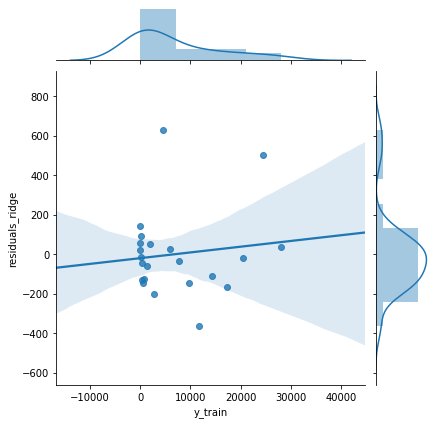

In [24]:
sns.jointplot("y_train", "residuals_ridge", data=df_residuals_ridge, kind="reg")

### Ridge model prediction

In [25]:
ridge_res_train = pd.read_csv('ridge_prediction/residuals_ridge_train_0211.csv')
del ridge_res_train['train_index']
ridge_res_test = pd.read_csv('ridge_prediction/residuals_ridge_test_0211.csv')
del ridge_res_test['test_index']

ridge_res_test.Timestamp = pd.to_datetime(ridge_res_test.date,format='%Y-%m-%d %H:%M') 
ridge_res_test.index = ridge_res_test.Timestamp
ridge_res_test = ridge_res_test.sort_index()

ridge_res_train.Timestamp = pd.to_datetime(ridge_res_train.date,format='%Y-%m-%d %H:%M') 
ridge_res_train.index = ridge_res_train.Timestamp
ridge_res_train = ridge_res_train.sort_index()

ridge_all = pd.concat([ridge_res_train,ridge_res_test])

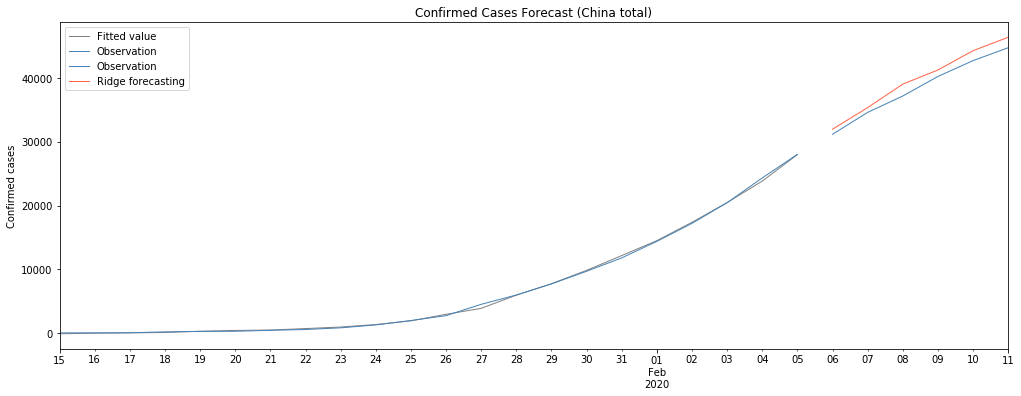

In [26]:
#Plotting data
ridge_res_train['predictions'].plot(figsize=(17,6), title= 'Confirmed Cases Forecast (China total)', fontsize=10,
                                        label= 'Fitted value',linewidth=1, color = 'grey')
ridge_res_train['y_train'].plot(figsize=(17,6),label= 'Observation',linewidth=1, color = 'steelblue')
ridge_res_test['y_test'].plot(figsize=(17,6), label= 'Observation', linewidth=1, color = 'steelblue')

ridge_res_test['predictions'].plot(figsize=(17,6), label= 'Ridge forecasting', color = 'tomato',linewidth=1)
plt.ylabel('Confirmed cases')
plt.xlabel('')
plt.legend()
plt.show()